<a href="https://colab.research.google.com/github/dkaratzas/DL2022-23/blob/main/Problems%208%20-%20RNNs/P8_RNNs.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

[![Open In SageMaker Studio Lab](https://studiolab.sagemaker.aws/studiolab.svg)](https://studiolab.sagemaker.aws/import/github/dkaratzas/DL2022-23/blob/main/Problems%208%20-%20RNNs/P8_RNNs.ipynb)

# Text generation with an RNN

In this notebook we will learn how to generate text with a Recurrent Neural Network.

We will work with a dataset of Shakespeare's writing from Andrej Karpathy's article [The Unreasonable Effectiveness of Recurrent Neural Networks](http://karpathy.github.io/2015/05/21/rnn-effectiveness/).

Given a sequence of characters from this data (for example "Shakespear"), we will train a model to predict the next character in the sequence ("e"). Longer sequences of text can be generated by calling the model repeatedly.

### Import the necessary modules

In [1]:
import torch
import torch.nn as nn
import torch.optim as optim
import numpy as np
from torch.utils.data import TensorDataset, DataLoader, Dataset

import matplotlib.pyplot as plt
from collections import Counter
import time
import os
import copy
print("PyTorch Version: ",torch.__version__)

PyTorch Version:  2.2.1+cu121


In [2]:
#If this cell fails you need to change the runtime of your colab notebook to GPU
# Go to Runtime -> Change Runtime Type and select GPU
assert torch.cuda.is_available(), "GPU is not enabled"

#  use gpu if available
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Using device:", device)

Using device: cuda


### Download the Shakespeare dataset

In [3]:
! wget https://storage.googleapis.com/download.tensorflow.org/data/shakespeare.txt

--2024-04-29 19:32:46--  https://storage.googleapis.com/download.tensorflow.org/data/shakespeare.txt
Resolving storage.googleapis.com (storage.googleapis.com)... 74.125.137.207, 142.250.141.207, 142.251.2.207, ...
Connecting to storage.googleapis.com (storage.googleapis.com)|74.125.137.207|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 1115394 (1.1M) [text/plain]
Saving to: ‘shakespeare.txt’

shakespeare.txt     100%[===================>]   1.06M  --.-KB/s    in 0.01s   

2024-04-29 19:32:46 (76.7 MB/s) - ‘shakespeare.txt’ saved [1115394/1115394]



###  Create a dataset class

For training we need a dataset of (input, label) pairs. Where input and label are sequences of characters. At each time step the input is the current character and the label is the next character. For example:

```
input = ['S', 'h', 'a', 'k', 'e', 's', 'p', 'e', 'a', 'r']
label = ['h', 'a', 'k', 'e', 's', 'p', 'e', 'a', 'r', 'e']
 ```

Actually we will vectorize the characters to convert them into numerical values.

```
input = [44, 7, 0, 10, 4, 18, 15, 4, 0, 17]
label = [7, 0, 10, 4, 18, 15, 4, 0, 17, 4]
```

where each integer value is a class label, and the number of classes is the number of unique characters in our training data (our vocabulary size).

In [4]:
Dataset?

In [50]:
class DatasetFromTextFile(Dataset):
    def __init__(self, filename, sequence_length):
        self.filename = filename
        self.sequence_length = sequence_length

        # The whole sequence of characters in the text file (including characters like the end of line character '\n', punctuation marks, etc.)
        self.chars = self.load_chars()
        # The list of unique characters (our vocabulary)
        self.uniq_chars = self.get_uniq_chars()

        # A dictionary with indices as keys and characters as values
        self.index_to_char = {index: char for index, char in enumerate(self.uniq_chars)}
        # A dictionary with characters as keys and indices as values
        self.char_to_index = {char: index for index, char in enumerate(self.uniq_chars)}

        # The whole sequence of character indexes
        # We want to vectorize our text using one-hot vectors at character level
        # But instead of using the one-hot vector we just keep the index of the 1 value
        self.chars_indices = [self.char_to_index[w] for w in self.chars]

        # Split the sequence into chunks of `sequence_length` characters
        # `x` is the input to the model and `y` is the output of the model
        # `y` is the same seuqence as `x` but one character shifted to the right.
        self.x, self.y = self.get_data()

    def load_chars(self):
        with open(self.filename) as fp:
            text = fp.read()
        print(f'Length of text: {len(text)} characters')
        return text

    def get_uniq_chars(self):
        char_counts = Counter(self.chars)
        uniq_chars = sorted(char_counts, key=char_counts.get, reverse=True)
        print(f'Unique characters (vocabulary size): {len(uniq_chars)}')
        return uniq_chars

    def get_data(self):
        x,y = [], []
        for index in range(0, len(self.chars_indices)-self.sequence_length, self.sequence_length):
            x.append(np.array(self.chars_indices[index:index+self.sequence_length]))
            y.append(np.array(self.chars_indices[index+1:index+self.sequence_length+1]))

        return  torch.from_numpy(np.array(x)), torch.from_numpy(np.array(y)).long()

    def __len__(self):
        return len(self.y)

    def __getitem__(self, idx):
        assert ((idx >= 0) & (idx < len(self.y))), "Dataset index out of range"
        return self.x[idx], self.y[idx]

Now we can use [`torch.utils.data.Dataloader`](https://pytorch.org/docs/stable/data.html) class to create the PyTorch dataloader.

In [51]:
# Create the dataset
sequence_length = 100
ShakespeareDataset = DatasetFromTextFile('shakespeare.txt', sequence_length)

print(f'We have {ShakespeareDataset.x.shape[0]} input sequence samples of length {ShakespeareDataset.x.shape[1]} \
and {ShakespeareDataset.y.shape[0]} label sequences of length {ShakespeareDataset.y.shape[1]}')

# Create the Torch DataLoader
batch_size = 64
train_loader = DataLoader(ShakespeareDataset, shuffle=True, batch_size=batch_size, drop_last=True)

Length of text: 1115394 characters
Unique characters (vocabulary size): 65
We have 11153 input sequence samples of length 100 and 11153 label sequences of length 100


## Build the model

Our model has three layers:

* `torch.nn.Embedding`: The input layer. A trainable lookup table that will map each character-ID (class ID) to a dense vector with `embedding_dim` dimensions;
* `torch.nn.GRU`: A type of RNN with `hidden_dim` units
* `torch.nn.Linear`: The output layer, with number of outputs as our vocabulary size (`len(dataset.uniq_chars)`). It outputs one logit for each character in the vocabulary. These are the log-likelihood of each character according to the model.


For each character the model looks up the embedding, runs the GRU one timestep with the embedding as input, and applies the dense layer to generate logits predicting the log-likelihood of the next character:

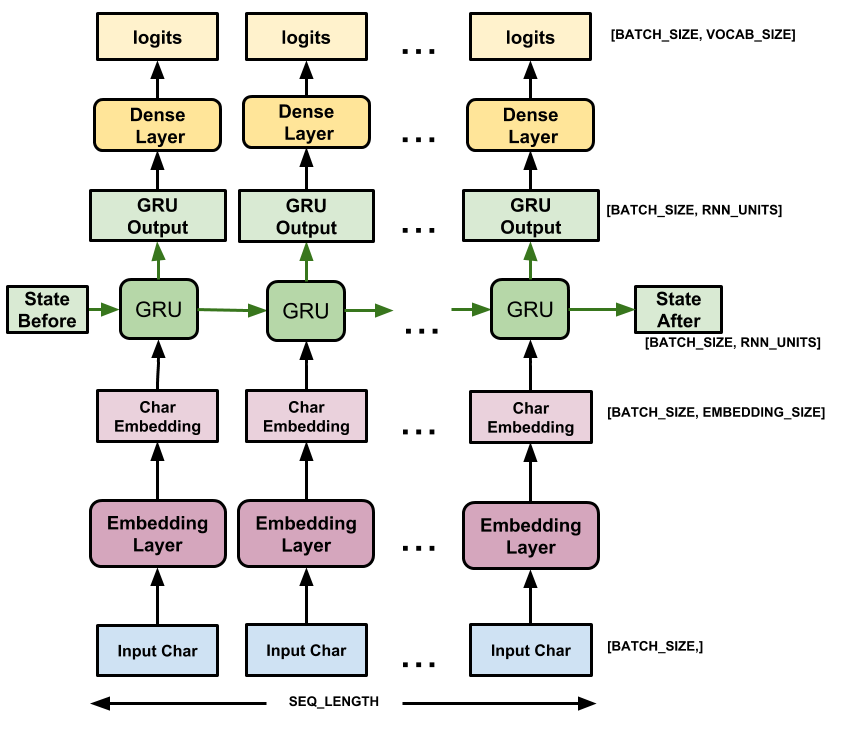

Image source: http://www.tensorflow.org

<span style="color:blue">
    
Let's complete the code of the `Model` class. We need to embed your input using an `nn.Embedding` layer, create a GRU with `n_layers`, and then compute the output logits.
    
</span>

In [7]:
class Model(nn.Module):
    def __init__(self, input_dim, embedding_dim, hidden_dim, output_dim, n_layers, drop_prob=0.):
        super(Model, self).__init__()
        self.hidden_dim = hidden_dim
        self.n_layers = n_layers

        # YOUR CODE HERE
        self.embedding = nn.Embedding(input_dim,embedding_dim)
        self.gru = nn.GRU(embedding_dim, hidden_dim, n_layers, batch_first=True)
        self.fc = nn.Linear(hidden_dim, output_dim)


    def forward(self, x, h):
        emb = self.embedding(x)
        out, h = self.gru(emb, h)
        out = self.fc(out)
        return out, h

    def init_hidden(self, batch_size):
        " Initialize the hidden state of the RNN to zeros"
        hidden = nn.Parameter(torch.zeros(self.n_layers, batch_size, self.hidden_dim))
        return hidden

Now we can instantiate the model as follows:

In [8]:
input_dim = len(ShakespeareDataset.uniq_chars)
embedding_dim = 300
hidden_dim = 1024
output_dim = len(ShakespeareDataset.uniq_chars)
n_layers = 2
drop_prob = 0.2

model = Model(input_dim, embedding_dim, hidden_dim, output_dim, n_layers, drop_prob).to(device)

print(model)

Model(
  (embedding): Embedding(65, 300)
  (gru): GRU(300, 1024, num_layers=2, batch_first=True)
  (fc): Linear(in_features=1024, out_features=65, bias=True)
)


## Quick Experiment

Let's create a string and pass it through our model

In [9]:
data = torch.tensor([ShakespeareDataset.char_to_index[w] for w in "Hello"])
print(data.shape)

torch.Size([5])


Our model expects a batch. We will create a batch of 1, using this one data point we have created

In [10]:
data = data.unsqueeze(0) # this adds one more dimension (the batch one) to our data
print(data.shape)

torch.Size([1, 5])


Time to pass this through our model. To do so, we need to (1) move our data to the same device like the model and (2) initialise the state of our RNN

In [11]:
data = data.to(device)
state = model.init_hidden(batch_size = 1) # remember that we will use just a single data point jere
state = state.to(device)
out, state = model(data, state) # The forward pass expects the current state as an argument, and returns the updated state in the output

print(out.shape)

torch.Size([1, 5, 65])


Our output returns 65 probability values for each character... We need to find which one is the maximum probability for each position, and convert it to the corresponding character

In [12]:
_, idxs = torch.max(out[0], dim = 1)

print([ShakespeareDataset.index_to_char[int(c)] for c in idxs])

['a', 'a', 'b', '-', 'X']


As expected both inputs and outputs have the same shape, and the predicted characters are just random since the model is not trained yet.

## Train the model

Training a language model is essentially a classification problem. Given the previous RNN state, and the input character at this time step, predict the class of the next character.

<span style="color:blue">

The loss function we shall use to train our model will be CrossEntropy
    
</span>

In [13]:
def train(dataloader, model, batch_size, sequence_length, num_epochs):
    model.train()

    criterion = nn.CrossEntropyLoss()
    optimizer = optim.Adam(model.parameters(), lr=0.001)

    losses = []
    for epoch in range(num_epochs):

        for batch, (x, y) in enumerate(dataloader):
            state = model.init_hidden(batch_size,device) # Start with a new state in each batch
            state = (state[0].to(device), state[1].to(device))

            x = x.to(device)
            y = y.to(device)
            optimizer.zero_grad()

            y_pred, state = model(x, state)
            loss = criterion(y_pred.transpose(1, 2), y)

            loss.backward()
            optimizer.step()

            if batch%30 == 0:
                print({ 'epoch': epoch, 'batch': batch, 'loss': loss.item() })
                losses.append(loss.item())
    return losses

Now train the model for 20 epochs and visualize the training loss curve.

In [ ]:
num_epochs = 20

losses = train(train_loader, model, batch_size, sequence_length, num_epochs)

{'epoch': 0, 'batch': 0, 'loss': 4.1759443283081055}
{'epoch': 0, 'batch': 30, 'loss': 2.242006778717041}
{'epoch': 0, 'batch': 60, 'loss': 1.9852349758148193}
{'epoch': 0, 'batch': 90, 'loss': 1.7637296915054321}
{'epoch': 0, 'batch': 120, 'loss': 1.6791006326675415}
{'epoch': 0, 'batch': 150, 'loss': 1.5641177892684937}
{'epoch': 1, 'batch': 0, 'loss': 1.5476897954940796}
{'epoch': 1, 'batch': 30, 'loss': 1.500546932220459}
{'epoch': 1, 'batch': 60, 'loss': 1.4560104608535767}
{'epoch': 1, 'batch': 90, 'loss': 1.4469975233078003}
{'epoch': 1, 'batch': 120, 'loss': 1.4380182027816772}
{'epoch': 1, 'batch': 150, 'loss': 1.4248871803283691}
{'epoch': 2, 'batch': 0, 'loss': 1.340619683265686}
{'epoch': 2, 'batch': 30, 'loss': 1.3434072732925415}
{'epoch': 2, 'batch': 60, 'loss': 1.3545196056365967}
{'epoch': 2, 'batch': 90, 'loss': 1.2922124862670898}
{'epoch': 2, 'batch': 120, 'loss': 1.324060082435608}
{'epoch': 2, 'batch': 150, 'loss': 1.3206851482391357}
{'epoch': 3, 'batch': 0, 'los

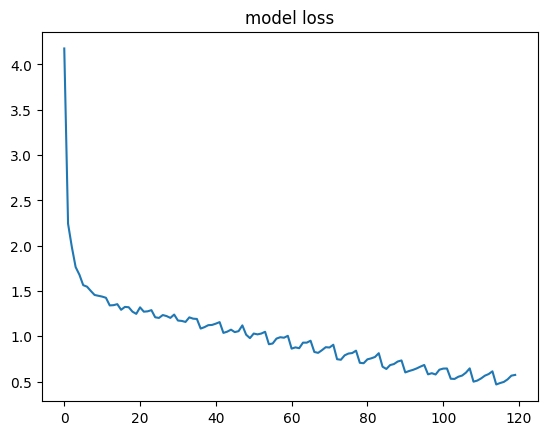

In [ ]:
# Visualize the loss evolution during training
plt.plot(losses)
plt.title('model loss')
plt.show()

## Try the trained model

Let's try again to predict some characters given the input sentence 'ROMEO:'. Now the predicted characters should be much better.

In [ ]:
with torch.no_grad():
    input_str = 'ROMEO:'

    state = model.init_hidden(batch_size=1)
    state = state.to(device)
    data = torch.tensor([[ShakespeareDataset.char_to_index[char] for char in input_str]]).to(device)
    output, state = model(data, state)

    _, predicted_idxs = torch.max(output[0], dim = 1)
    predicted_idxs = predicted_idxs.cpu().numpy()

    predicted_str = ''.join([ShakespeareDataset.index_to_char[idx] for idx in predicted_idxs])

    print(f'Input shape: {data.size()}')
    print(f'Output shape: {data.size()}')
    print(f'Input string: {input_str}')
    print(f'Output string: {predicted_str}')

Input shape: torch.Size([1, 6])
Output shape: torch.Size([1, 6])
Input string: ROMEO:
Output string: eMEO:



## Generate new text

In [38]:
def predict(dataset, model, text, next_chars=1000):
    model.eval()

    chars = [char for char in text]
    state = model.init_hidden(1,device) # Start with a new state in each batch
    state = (state[0].to(device), state[1].to(device))

    # we start by feeding all the input characters to our model
    x = torch.tensor([dataset.char_to_index[char] for char in chars])
    x = x.unsqueeze(0) # create a batch of 1
    x = x.to(device)

    for i in range(0, next_chars):

        y_pred, state = model(x, state)

        last_char_logits = y_pred[0][-1]
        p = torch.nn.functional.softmax(last_char_logits, dim=0).detach().cpu().numpy()
        char_index = np.random.choice(len(last_char_logits), p=p)
        chars.append(dataset.index_to_char[char_index])

        # the output of the model (a single character index) becomes the input at next iteration
        x = torch.tensor([[char_index]])
        x = x.to(device)

    return chars

#predicted = predict(ShakespeareDataset, model,'ROMEO:')
#print(''.join(predicted))

While some of the sentences are grammatically correct, most do not make sense. The model has not learned the meaning of words (we would need a much larger corpus for that, and probably a word level language model), but consider the following:

* The model is character-based. When training started, the model did not know how to spell an English word, or that words were even a unit of text. Now it does a pretty decent job on spelling.

* The structure of the output resembles a play, blocks of text generally begin with a speaker name, in all capital letters similar to the dataset.

* The model is trained on small batches of text (100 characters each), and is still able to generate a longer sequence of text with coherent structure.



<span style="color:blue">
    
Let's build two new models: one using Simple RNN cells (torch.nn.RNN) instead of GRUs(torch.nn.RNN), and the other using LSTMs (torch.nn.LSTM). We train all three models (GRU, LSTM, SimpleRNN) for 30 epochs and compare the loss curves. Optionally we can try different configurations: embedding dimension, hidden layers dimensions, number of layers, etc.
    
</span>

In [14]:

class RNNModel(nn.Module):
    def __init__(self, input_dim, embedding_dim, hidden_dim, output_dim, n_layers, drop_prob=0.):
        super(RNNModel, self).__init__()
        self.hidden_dim = hidden_dim
        self.n_layers = n_layers

        
        self.embedding = nn.Embedding(input_dim,embedding_dim)
        self.rnn = nn.RNN(embedding_dim, hidden_dim, n_layers, batch_first=True)
        self.fc = nn.Linear(hidden_dim, output_dim)


    def forward(self, x, h):
        emb = self.embedding(x)
        out, h = self.rnn(emb, h)
        out = self.fc(out)
        return out, h

    def init_hidden(self, batch_size):
        " Initialize the hidden state of the RNN to zeros"
        hidden = nn.Parameter(torch.zeros(self.n_layers, batch_size, self.hidden_dim))
        return hidden

class LSTMModel(nn.Module):
    def __init__(self, input_dim, embedding_dim, hidden_dim, output_dim, n_layers, drop_prob=0.):
        super(LSTMModel, self).__init__()
        self.hidden_dim = hidden_dim
        self.n_layers = n_layers

        # YOUR CODE HERE
        self.embedding = nn.Embedding(input_dim,embedding_dim)
        self.lstm = nn.LSTM(embedding_dim, hidden_dim, n_layers, batch_first=True)
        self.fc = nn.Linear(hidden_dim, output_dim)


    def forward(self, x, h):
        emb = self.embedding(x)
        out, h = self.lstm(emb, h)
        out = self.fc(out)
        return out, h

    def init_hidden(self, batch_size, device):  # Added device argument
        # Initialize hidden state with zeros
        weight = next(self.parameters()).data
        hidden = (weight.new(self.n_layers, batch_size, self.hidden_dim).zero_().to(device),
                  weight.new(self.n_layers, batch_size, self.hidden_dim).zero_().to(device))  # Ensure tensors are on the same device
        return hidden

In [18]:
#RNN model
input_dim = len(ShakespeareDataset.uniq_chars)
embedding_dim = 300
hidden_dim = 1024
output_dim = len(ShakespeareDataset.uniq_chars)
n_layers = 2
drop_prob = 0.2

model_rnn = RNNModel(input_dim, embedding_dim, hidden_dim, output_dim, n_layers, drop_prob).to(device)

print(model_rnn)

RNNModel(
  (embedding): Embedding(65, 300)
  (rnn): RNN(300, 1024, num_layers=2, batch_first=True)
  (fc): Linear(in_features=1024, out_features=65, bias=True)
)


In [19]:
num_epochs = 20

losses_rnn = train(train_loader, model_rnn, batch_size, sequence_length, num_epochs)

{'epoch': 0, 'batch': 0, 'loss': 4.1723527908325195}
{'epoch': 0, 'batch': 30, 'loss': 2.239696979522705}
{'epoch': 0, 'batch': 60, 'loss': 2.0286808013916016}
{'epoch': 0, 'batch': 90, 'loss': 1.9110277891159058}
{'epoch': 0, 'batch': 120, 'loss': 1.7758651971817017}
{'epoch': 0, 'batch': 150, 'loss': 1.772497296333313}
{'epoch': 1, 'batch': 0, 'loss': 1.7002995014190674}
{'epoch': 1, 'batch': 30, 'loss': 1.6312986612319946}
{'epoch': 1, 'batch': 60, 'loss': 1.6226234436035156}
{'epoch': 1, 'batch': 90, 'loss': 1.5580925941467285}
{'epoch': 1, 'batch': 120, 'loss': 1.5245981216430664}
{'epoch': 1, 'batch': 150, 'loss': 1.537711501121521}
{'epoch': 2, 'batch': 0, 'loss': 1.4984349012374878}
{'epoch': 2, 'batch': 30, 'loss': 1.5024687051773071}
{'epoch': 2, 'batch': 60, 'loss': 1.4625558853149414}
{'epoch': 2, 'batch': 90, 'loss': 1.474258303642273}
{'epoch': 2, 'batch': 120, 'loss': 1.4787678718566895}
{'epoch': 2, 'batch': 150, 'loss': 1.4145593643188477}
{'epoch': 3, 'batch': 0, 'los

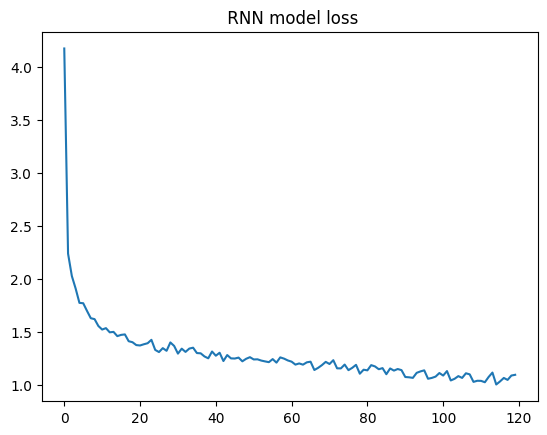

In [20]:
plt.plot(losses_rnn)
plt.title(' RNN model loss')
plt.show()

In [15]:
#LSTM model
model_lstm = LSTMModel(input_dim, embedding_dim, hidden_dim, output_dim, n_layers, drop_prob).to(device)

print(model_lstm)

LSTMModel(
  (embedding): Embedding(65, 300)
  (lstm): LSTM(300, 1024, num_layers=2, batch_first=True)
  (fc): Linear(in_features=1024, out_features=65, bias=True)
)


In [17]:
num_epochs = 20
losses_lstm = train(train_loader, model_lstm, batch_size, sequence_length, num_epochs)

{'epoch': 0, 'batch': 0, 'loss': 4.178560256958008}
{'epoch': 0, 'batch': 30, 'loss': 2.2847108840942383}
{'epoch': 0, 'batch': 60, 'loss': 1.9518262147903442}
{'epoch': 0, 'batch': 90, 'loss': 1.801673412322998}
{'epoch': 0, 'batch': 120, 'loss': 1.6757174730300903}
{'epoch': 0, 'batch': 150, 'loss': 1.5777775049209595}
{'epoch': 1, 'batch': 0, 'loss': 1.510343313217163}
{'epoch': 1, 'batch': 30, 'loss': 1.5001434087753296}
{'epoch': 1, 'batch': 60, 'loss': 1.4445159435272217}
{'epoch': 1, 'batch': 90, 'loss': 1.4219539165496826}
{'epoch': 1, 'batch': 120, 'loss': 1.4265767335891724}
{'epoch': 1, 'batch': 150, 'loss': 1.4529870748519897}
{'epoch': 2, 'batch': 0, 'loss': 1.3302695751190186}
{'epoch': 2, 'batch': 30, 'loss': 1.3254350423812866}
{'epoch': 2, 'batch': 60, 'loss': 1.3308157920837402}
{'epoch': 2, 'batch': 90, 'loss': 1.3793509006500244}
{'epoch': 2, 'batch': 120, 'loss': 1.3309426307678223}
{'epoch': 2, 'batch': 150, 'loss': 1.2752128839492798}
{'epoch': 3, 'batch': 0, 'lo

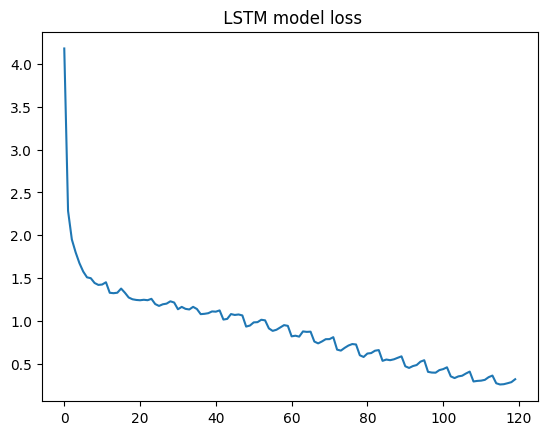

In [19]:
plt.plot(losses_lstm)
plt.title(' LSTM model loss')
plt.show()

The can observe that the model is the LSTM model

<span style="color:blue">

We will train our best model on a different dataset. Use the 'inaugural' corpus of the [NLTK](https://www.nltk.org/) library. Once trained generate some text with as we did for the model trained on the Shakespeare dataset. Compare the generated texts with both models using the smae "seed" (input) text.
    
</span>

The Natural Language Toolkit, or more commonly NLTK, is a suite of datasets, libraries and models for symbolic and statistical natural language processing (NLP). The Inaugural Address Corpus contains the US presidential inaugural addresses from 1789 to 2017. The following code loads the 'inaugural' corpus:

In [18]:
import nltk
nltk.download('inaugural')

inaugural = nltk.corpus.inaugural
text = inaugural.raw()

print(f'Length of text: {len(text)} characters')

Length of text: 807276 characters


[nltk_data] Downloading package inaugural to /root/nltk_data...
[nltk_data]   Unzipping corpora/inaugural.zip.


In [30]:
print(text[:1000])

Fellow-Citizens of the Senate and of the House of Representatives:

Among the vicissitudes incident to life no event could have filled me with greater anxieties than that of which the notification was transmitted by your order, and received on the 14th day of the present month. On the one hand, I was summoned by my Country, whose voice I can never hear but with veneration and love, from a retreat which I had chosen with the fondest predilection, and, in my flattering hopes, with an immutable decision, as the asylum of my declining years -- a retreat which was rendered every day more necessary as well as more dear to me by the addition of habit to inclination, and of frequent interruptions in my health to the gradual waste committed on it by time. On the other hand, the magnitude and difficulty of the trust to which the voice of my country called me, being sufficient to awaken in the wisest and most experienced of her citizens a distrustful scrutiny into his qualifications, could not bu

In [26]:
file_path = "./inaugural_file.txt"

# Write the text to the file
with open(file_path, "w") as file:
    file.write(text)

In [27]:
# Create the dataset
sequence_length = 100
inauguralText = DatasetFromTextFile(file_path, sequence_length)

print(f'We have {inauguralText.x.shape[0]} input sequence samples of length {inauguralText.x.shape[1]} \
and {inauguralText.y.shape[0]} label sequences of length {inauguralText.y.shape[1]}')

# Create the Torch DataLoader
batch_size = 64
train_loader = DataLoader(inauguralText, shuffle=True, batch_size=batch_size, drop_last=True)

Length of text: 807276 characters
Unique characters (vocabulary size): 85
We have 8072 input sequence samples of length 100 and 8072 label sequences of length 100


In [28]:
input_dim = len(inauguralText.uniq_chars)
embedding_dim = 300
hidden_dim = 1024
output_dim = len(inauguralText.uniq_chars)
n_layers = 2
drop_prob = 0.2

model_LSTM = LSTMModel(input_dim, embedding_dim, hidden_dim, output_dim, n_layers, drop_prob).to(device)

print(model_LSTM)

LSTMModel(
  (embedding): Embedding(85, 300)
  (lstm): LSTM(300, 1024, num_layers=2, batch_first=True)
  (fc): Linear(in_features=1024, out_features=85, bias=True)
)


In [29]:
num_epochs = 20

lossesLSTM = train(train_loader, model_LSTM, batch_size, sequence_length, num_epochs)

{'epoch': 0, 'batch': 0, 'loss': 4.446130275726318}
{'epoch': 0, 'batch': 30, 'loss': 2.2849957942962646}
{'epoch': 0, 'batch': 60, 'loss': 1.833959937095642}
{'epoch': 0, 'batch': 90, 'loss': 1.6759681701660156}
{'epoch': 0, 'batch': 120, 'loss': 1.5210093259811401}
{'epoch': 1, 'batch': 0, 'loss': 1.4626669883728027}
{'epoch': 1, 'batch': 30, 'loss': 1.3529326915740967}
{'epoch': 1, 'batch': 60, 'loss': 1.3631963729858398}
{'epoch': 1, 'batch': 90, 'loss': 1.3025555610656738}
{'epoch': 1, 'batch': 120, 'loss': 1.2829264402389526}
{'epoch': 2, 'batch': 0, 'loss': 1.2112559080123901}
{'epoch': 2, 'batch': 30, 'loss': 1.1990503072738647}
{'epoch': 2, 'batch': 60, 'loss': 1.2180384397506714}
{'epoch': 2, 'batch': 90, 'loss': 1.2144882678985596}
{'epoch': 2, 'batch': 120, 'loss': 1.1938689947128296}
{'epoch': 3, 'batch': 0, 'loss': 1.1644848585128784}
{'epoch': 3, 'batch': 30, 'loss': 1.1656922101974487}
{'epoch': 3, 'batch': 60, 'loss': 1.1543787717819214}
{'epoch': 3, 'batch': 90, 'loss

In [43]:
with torch.no_grad():
    input_str = 'Among the vicissitudes incident'

    state = model_LSTM.init_hidden(1,device) # Start with a new state in each batch
    state = (state[0].to(device), state[1].to(device))
    data = torch.tensor([[inauguralText.char_to_index[char] for char in input_str]]).to(device)
    output, state = model_LSTM(data, state)

    _, predicted_idxs = torch.max(output[0], dim = 1)
    predicted_idxs = predicted_idxs.cpu().numpy()

    predicted_str = ''.join([inauguralText.index_to_char[idx] for idx in predicted_idxs])

    print(f'Input shape: {data.size()}')
    print(f'Output shape: {data.size()}')
    print(f'Input string: {input_str}')
    print(f'Output string: {predicted_str}')

Input shape: torch.Size([1, 31])
Output shape: torch.Size([1, 31])
Input string: Among the vicissitudes incident
Output string: necg the neciositudes intident 


In [47]:
predicted = predict(inauguralText, model_LSTM,'Among the vicissitudes incident')
print(''.join(predicted))

Among the vicissitudes incident to avoid the Constitution or because experience a step while it lasts, but it should always be unterrusted. The proceedings of America -- but a dollation should in history in leading the lifeblished by long-sides than by the common who hang in the family relation to all peoples of the Treasury Department of our resources, virtual monarchies, by preventing this genius influence and savings debts at day to the favor and resources of the whole is better than the consent of the courts shall be received sustained by one and all of us serily and with led to oppose ambassages for the circumstances of our citizens who fear themselves too much better conditions possible to acclaim an era of good feeling than it would be despaired of.

It is the duty of that object? It may be thought to be the dictated at the disposal to armies and all forms of human oppression.

Let us be proud that under those thoughts that belongs us today. It is that the Congress in its stead 

In [54]:
# Model trained on the Shakespeare text
predicted = predict(inauguralText, model_lstm,'Among the vicissitudes incident')
print(''.join(predicted))

Among the vicissitudes incidenti tie atorm oyyhger oy tief'llj7jAjq
lIsc vp tint mou co .roteatp wihgi ha too airewcdml.ro.er to iha IcTnstnbep whti n yrhesc oy DomlBnxhsb tie .ohst oy xhsbakllHhrat Burcerer
lv tioubit so dosberkllCjWSAjz
lUe nre toubierp ,rotierp tinsxakllPCWN;jzAjq
lUintp whdd tie iosour iesge'llBIq;vNz
lRou inTep fm dhebeplRou inTe fnce yor Thgtorm
 nsc iere gofea mour ,enra
lUedd .roThcea tint mou anmp aure os mour iosourkllOIzAvSPz
lFut ties v inTe so gnuae to ,hc tief yood
lIsc wies tiou xhdh-atp Wur whyep tint mou anw iuf,dmlAint tiem co aee tiee iere n worc oy ,dngx'llSWqAONBFjqCISE
lqenc o-er tiha .n.er wihgi ha n atrnw,errhed nsc usDuatormlUies tiou aioudcat ,enr fm fenshsbp wihgi to inTelEoti tiht true ceyesgekll8NjjS jCv¡IFjAO
lAioubi ynr fore yentor" so aootiers ,onatlIa tie .dnhs ceeca whdd .ur.oaep tiha outwnrcManhstkllEN:j WH INBjqCj
lv co ,eaeegi mour brnge to .nrcos fe
lWp fugi ,etter wihgi mou werep Hrhnp to tie iodm anhstalIsc iere ha gofe to .urgin

We observe that the model trained on the Shakespeare text is not able to generate something meaningful given the inauguralText.
This could happen because the vocabulary and the style of the 2 texts is different